In [1]:
%matplotlib inline

import scipy.stats as st
import numpy as np
import pandas as pd
from matplotlib import pyplot

## Container startup time distribution
The output of this section is an animation of the startup time of Eliot containers over a time series extracted from Prometheus. The dashboard panel "Container startup time" has been used, where the prometheus query is 
```
- sort(kube_pod_created{namespace="eliot"}) + kube_pod_start_time{namespace="eliot"}
```

To export the data you need to go the panel in Grafana, go for the query inspector and export the CSV with the "Join by time" option in the Transformer; be sure to choose the correct time frame.

In [82]:
np.random.seed(45873)
df = pd.read_csv("data/startup_time.csv")

Here we just show the final distribution

In [83]:
timestamp = df.tail(1)['Time']
containers_activation_time = df.tail(1).drop('Time', axis=1)
bins = np.arange(x_min,x_max, 0.5)

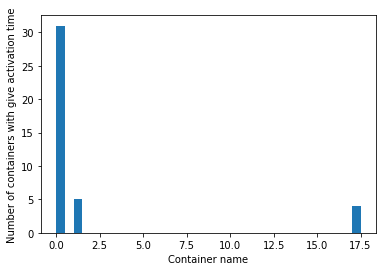

In [84]:
pyplot.hist(containers_activation_time, bins=bins)
pyplot.xlabel('Container name')
pyplot.ylabel('Number of containers with give activation time')
pyplot.show()

Here we generate the animation

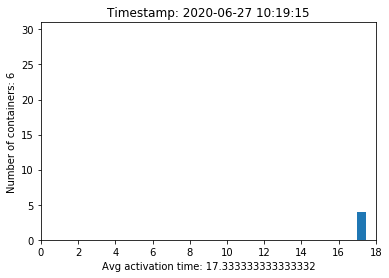

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

# Get correct limits from last time series
containers_activation_time = df.iloc[-1][1:].dropna()
number_of_frames = len(df.index)
x_min, x_max = int(min(containers_activation_time)), int(max(containers_activation_time))
y_min, y_max = 0, containers_activation_time.value_counts().max()
bins = np.arange(x_min,x_max, 0.5)

def update_hist(i):
    pyplot.cla()
    timestamp = df.iloc[i][0]
    containers_activation_time = df.iloc[i][1:].dropna()

    pyplot.hist(containers_activation_time, bins)
    pyplot.xlabel('Avg activation time: ' + str(np.mean(containers_activation_time)))
    pyplot.ylabel('Number of containers: ' + str(len(containers_activation_time)))
    pyplot.title('Timestamp: ' + timestamp)
    pyplot.xlim(x_min,x_max)
    pyplot.ylim(y_min,y_max)
    
animation = animation.FuncAnimation(fig, update_hist, number_of_frames, repeat=False)
animation.save('containers_startup_time.mp4')
plt.show()



## System Load of a single test

In [2]:
TEST_NUMBER = 6
RUN_NUMBER = 3

#Retrieve the start and the end time for each test
def retrieve_test_times(index, test_times):
    start_time = []
    end_time = []

    for test in test_times:
        time = test.split(",")
        date = time[0] + " " + time[1]
        if "Starting test " + str(index) in test:
            start_time.append(date)
        elif "Test " + str(index) + " stabilization period elapsed" in test:
            end_time.append(date)
    return start_time, end_time


#Trasform NAN value in value
def trasform_nan_to_value(test_values):
    prev_value = 0
    for i in range(len(test_values)):
        if i > 0:
            prev_value = test_values[i-1]
        if pd.isna(test_values[i]):
            test_values[i] = prev_value
    return test_values


#Retrieve total seconds
def retrieve_total_seconds(start_time, end_time):
    start_datetime =pd.to_datetime(start_time, format='%Y-%m-%d %H:%M:%S')
    end_datetime = pd.to_datetime(end_time, format='%Y-%m-%d %H:%M:%S')
    delta_time = end_datetime - start_datetime
    seconds = delta_time.total_seconds()
    return seconds

#Get the minimum duration and scale the values to that duration
def fix_duration(values, times):
    min = 1000
    for time in times:
        if time < min:
            min = time
    
    new_values = []
    for value in values:
        new_value = []
        for index in range(int(min)):
            new_value.append(value[index])
        new_values.append(new_value)
    return min, new_values

def compute_mean(values, length):
    mean = []
    for i in range(length):
        total = 0
        for j in range(RUN_NUMBER):
            total += values[j][i]
        mean_value = total/RUN_NUMBER
        mean.append(mean_value)
    return mean

def retrieve_start_and_end_time(test_times):
    test_time = {}
    start_time = []
    end_time = []

    for index in range(TEST_NUMBER):
        start_time, end_time = retrieve_test_times(index + 1, test_times)
        test_time["Start_0" + str(index + 1)] = start_time
        test_time["End_0" + str(index + 1)] = end_time
    return test_time

def retrieve_test_values(df01, df02, df03, test_time):
    df = 0
    dict_test_values = {}

    for i in range(TEST_NUMBER):
        dict_test_values["Test_" + str(i + 1) + "_values"] = []
        dict_test_values["Test_" + str(i + 1) + "_time"] = []
        for j in range(RUN_NUMBER):
            if j == 0:
                df = df01
            elif j == 1:
                df = df02
            else:
                df = df03

            test_interval = pd.Interval(pd.Timestamp(test_time["Start_0" + str(i + 1)][j]), pd.Timestamp(test_time["End_0" + str(i + 1)][j]), closed="left")
            test_values = []
            test_seconds = []

            for time in df["Time"]:
                index = df[df['Time']==time].index.values.astype(int)[0]
                time = pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S')
                if time in test_interval:
                    test_values.append(df["Value"][index])

            #test_values = trasform_nan_to_value(test_values)
            total_seconds = retrieve_total_seconds(test_time["Start_0" + str(i + 1)][j], test_time["End_0" + str(i + 1)][j])

            dict_test_values["Test_" + str(i + 1) + "_values"].append(test_values)
            dict_test_values["Test_" + str(i + 1) + "_time"].append(total_seconds)
    return dict_test_values

In [44]:
df_sl01 = pd.read_csv("data/system-load/system_load01.csv")
print(df_sl01)
df_sl02 = pd.read_csv("data/system-load/system_load02.csv")
print(df_sl02)
df_sl03 = pd.read_csv("data/system-load/system_load03.csv")
print(df_sl03)


test_times_file = open("data/system-load/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time      Value
0     2020-08-23 13:30:32   6.430000
1     2020-08-23 13:30:33   6.430000
2     2020-08-23 13:30:34   6.430000
3     2020-08-23 13:30:35   6.430000
4     2020-08-23 13:30:36   6.358333
...                   ...        ...
3268  2020-08-23 14:25:00  18.390000
3269  2020-08-23 14:25:01  18.390000
3270  2020-08-23 14:25:02  18.895000
3271  2020-08-23 14:25:03  19.400000
3272  2020-08-23 14:25:04  19.400000

[3273 rows x 2 columns]
                     Time  Value
0     2020-08-23 19:45:19   2.30
1     2020-08-23 19:45:20   2.30
2     2020-08-23 19:45:21   2.30
3     2020-08-23 19:45:22   2.30
4     2020-08-23 19:45:23   2.34
...                   ...    ...
2957  2020-08-23 20:34:36  34.39
2958  2020-08-23 20:34:37  34.39
2959  2020-08-23 20:34:38  34.39
2960  2020-08-23 20:34:39  34.28
2961  2020-08-23 20:34:40  34.28

[2962 rows x 2 columns]
                     Time   Value
0     2020-08-23 20:45:31   3.310
1     2020-08-23 20:45:32   3.310
2     20

In [45]:
test_time = retrieve_start_and_end_time(test_times)
dict_test_values = retrieve_test_values(df_sl01, df_sl02, df_sl03, test_time)

In [46]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration(values, times)

In [47]:
for index_test in range(TEST_NUMBER):
    length = int(dict_test_values["Test_" + str(index_test + 1) + "_time"])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"] = compute_mean(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

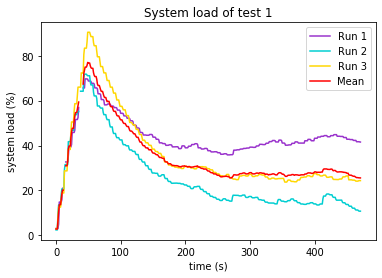

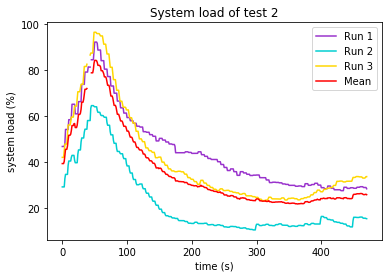

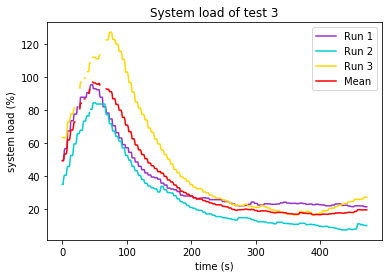

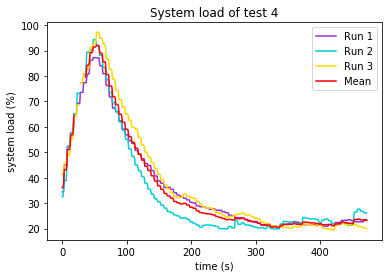

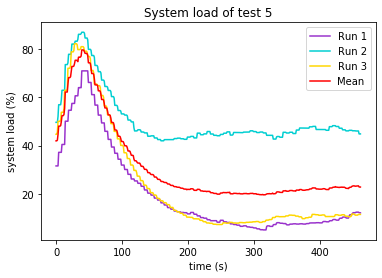

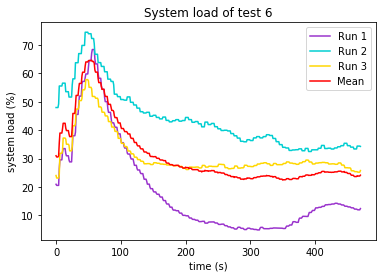

In [48]:
import matplotlib.pyplot as plt

for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    ax.set_title('System load of test ' + str(index_test + 1))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('system load (%)')
    leg = ax.legend();
    plt.show()

## System Load of all tests

In [49]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"])

dict_test["times"], dict_test["values"] = fix_duration(dict_test["values"], dict_test["times"])

In [12]:
poisson = np.random.poisson(90, 100)

In [ ]:


# the bins should be of integer width, because poisson is an integer distribution
bins = np.arange(11) - 0.5
entries, bin_edges, patches = plt.hist(data, bins=bins, density=True, label='Data')

# calculate bin centres
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])



# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries)

# plot poisson-deviation with fitted parameter
x_plot = np.arange(0, 15)

plt.plot(
    x_plot,
    fit_function(x_plot, *parameters),
    marker='o', linestyle='',
    label='Fit result',
)

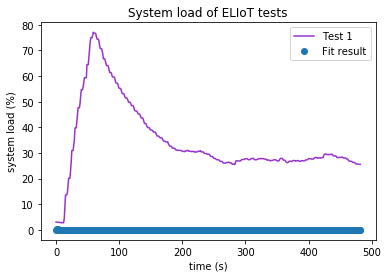

In [71]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)


fig, ax = plt.subplots()
    
for index in range(1):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
    
    
    parameters, cov_matrix = curve_fit(fit_function, x, y)
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

   
    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    x_plot = np.arange(0, 500)

    plt.plot(
        x,
        fit_function(x, parameters),
        marker='o', linestyle='',
        label='Fit result',
    )
    leg = ax.legend();
ax.set_title('System load of ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('system load (%)')
plt.show()

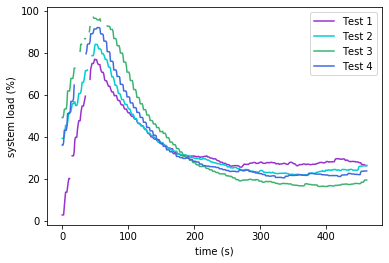

In [50]:
fig, ax = plt.subplots()
        
for index in range(TEST_NUMBER - 2):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('System load of ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('system load (%)')
plt.savefig("system_load_ELIot_tests.png")

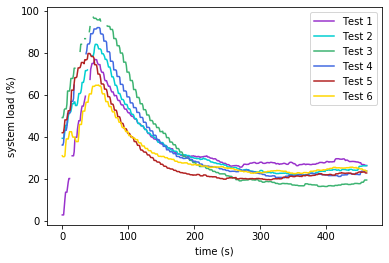

In [51]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('System load of all tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('system load (%)')
plt.savefig("system_load_all_tests.png")

# Memory of single test

In [152]:
TEST_NUMBER = 6
RUN_NUMBER = 3

#Get the minimum duration and scale the values to that duration
def fix_duration(values, times):
    min = 1000
    for value in values:
        if len(value) < min:
            min = len(value)
    
    new_values = []
    for value in values:
        new_value = []
        for index in range(int(min)):
            new_value.append(value[index])
        new_values.append(new_value)
        
    new_times = []
    for time in times:
        new_time = []
        for index in range(int(min)):
            new_time.append(time[index])
        new_times.append(new_time)
    return new_times, new_values

In [157]:
df_m01 = pd.read_csv("data/memory/memory01.csv")
print(df_m01)
df_m02 = pd.read_csv("data/memory/memory02.csv")
print(df_m02)
df_m03 = pd.read_csv("data/memory/memory03.csv")
print(df_m03)


test_times_file = open("data/memory/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time      Value
0     2020-08-23 13:30:32  22.084094
1     2020-08-23 13:30:34  22.082534
2     2020-08-23 13:30:36  22.072702
3     2020-08-23 13:30:38  22.085417
4     2020-08-23 13:30:40  22.083513
...                   ...        ...
1632  2020-08-23 14:24:56  33.139974
1633  2020-08-23 14:24:58  33.134032
1634  2020-08-23 14:25:00  33.128688
1635  2020-08-23 14:25:02  33.147559
1636  2020-08-23 14:25:04  33.151468

[1637 rows x 2 columns]
                     Time      Value
0     2020-08-23 19:45:18  23.917014
1     2020-08-23 19:45:20  23.915264
2     2020-08-23 19:45:22  23.904518
3     2020-08-23 19:45:24  23.897111
4     2020-08-23 19:45:26  23.898386
...                   ...        ...
1477  2020-08-23 20:34:32  38.910138
1478  2020-08-23 20:34:34  38.914716
1479  2020-08-23 20:34:36  38.925344
1480  2020-08-23 20:34:38  38.919105
1481  2020-08-23 20:34:40  38.905376

[1482 rows x 2 columns]
                     Time      Value
0     2020-08-23 20:45:30

In [158]:
test_time = retrieve_start_and_end_time(test_times)

In [159]:
df = 0
dict_test_values = {}

for i in range(TEST_NUMBER):
    dict_test_values["Test_" + str(i + 1) + "_values"] = []
    dict_test_values["Test_" + str(i + 1) + "_time"] = []
    for j in range(RUN_NUMBER):
        if j == 0:
            df = df_m01
        elif j == 1:
            df = df_m02
        else:
            df = df_m03

        test_interval = pd.Interval(pd.Timestamp(test_time["Start_0" + str(i + 1)][j]), pd.Timestamp(test_time["End_0" + str(i + 1)][j]), closed="left")
        test_values = []
        test_seconds = []

        for time in df["Time"]:
            index = df[df['Time']==time].index.values.astype(int)[0]
            time = pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S')
            if time in test_interval:
                test_values.append(df["Value"][index])
                end_datetime = pd.to_datetime(test_time["End_0" + str(i + 1)][j], format='%Y-%m-%d %H:%M:%S')
                delta_time = end_datetime - time
                seconds = delta_time.total_seconds()
                test_seconds.append(seconds)

        total_seconds = retrieve_total_seconds(test_time["Start_0" + str(i + 1)][j], test_time["End_0" + str(i + 1)][j])

        seconds = []
        for second in test_seconds:
            sec = total_seconds - second
            seconds.append(sec)
                                   
        dict_test_values["Test_" + str(i + 1) + "_values"].append(test_values)
        dict_test_values["Test_" + str(i + 1) + "_time"].append(seconds)

In [160]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration(values, times)

In [162]:
for index_test in range(TEST_NUMBER):
    length = len(dict_test_values["Test_" + str(index_test + 1) + "_time"][0])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"]= compute_mean(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

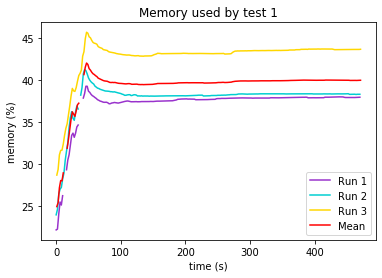

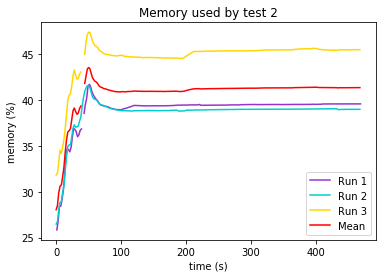

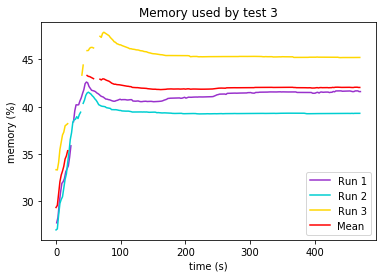

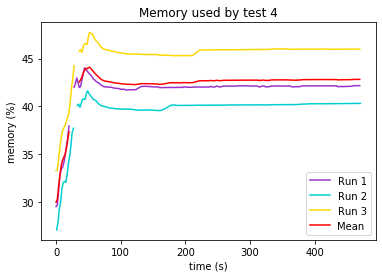

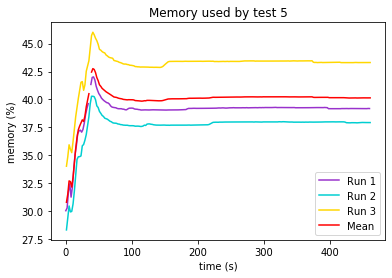

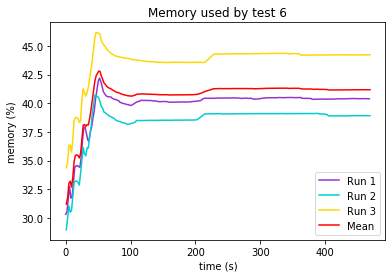

In [164]:
import matplotlib.pyplot as plt

for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = dict_test_values["Test_" + str(index_test + 1) + "_time"][index]
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = dict_test_values["Test_" + str(index_test + 1) + "_time"][index]
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    ax.set_title('Memory used by test ' + str(index_test + 1))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('memory (%)')
    leg = ax.legend();
    plt.show()

# Memory of all tests

In [165]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"][0])

dict_test["times"], dict_test["values"] = fix_duration(dict_test["values"], dict_test["times"])

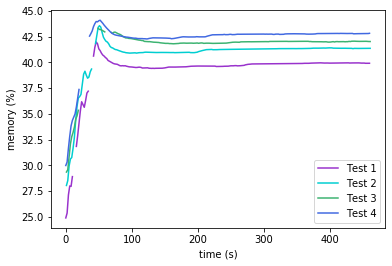

In [166]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER - 2):
    x = dict_test["times"][index]
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('Memory used in ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('memory (%)')
plt.savefig("memory_ELIot_tests.png")

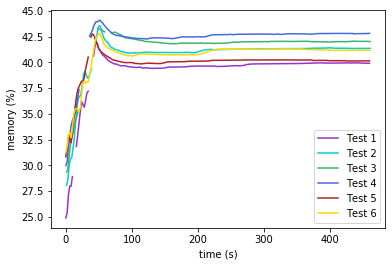

In [167]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = dict_test["times"][index]
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('Memory used in all tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('memory (%)')
plt.savefig("memory_all_tests.png")

# Throughput of a single test

In [185]:
#Get the minimum duration and scale the values to that duration
def fix_duration(values, times):
    min = 1000
    for value in values:
        if len(value) < min:
            min = len(value)
    
    new_values = []
    for value in values:
        new_value = []
        for index in range(int(min)):
            new_value.append(value[index])
        new_values.append(new_value)
    return min, new_values

In [186]:
df_t01 = pd.read_csv("data/throughput/throughput01.csv")
print(df_t01)
df_t02 = pd.read_csv("data/throughput/throughput02.csv")
print(df_t02)
df_t03 = pd.read_csv("data/throughput/throughput03.csv")
print(df_t03)


test_times_file = open("data/throughput/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time  Value
0     2020-08-23 13:30:32    NaN
1     2020-08-23 13:30:33    NaN
2     2020-08-23 13:30:34    NaN
3     2020-08-23 13:30:35    NaN
4     2020-08-23 13:30:36    NaN
...                   ...    ...
3268  2020-08-23 14:25:00    NaN
3269  2020-08-23 14:25:01    NaN
3270  2020-08-23 14:25:02    NaN
3271  2020-08-23 14:25:03    NaN
3272  2020-08-23 14:25:04    NaN

[3273 rows x 2 columns]
                     Time     Value
0     2020-08-23 19:45:19       NaN
1     2020-08-23 19:45:20       NaN
2     2020-08-23 19:45:21       NaN
3     2020-08-23 19:45:22       NaN
4     2020-08-23 19:45:23       NaN
...                   ...       ...
2957  2020-08-23 20:34:36  4.818078
2958  2020-08-23 20:34:37  4.854695
2959  2020-08-23 20:34:38  4.891313
2960  2020-08-23 20:34:39  4.927930
2961  2020-08-23 20:34:40  5.300832

[2962 rows x 2 columns]
                     Time     Value
0     2020-08-23 20:45:31       NaN
1     2020-08-23 20:45:32       NaN
2     2020-08-

In [ ]:
test_time = retrieve_start_and_end_time(test_times)
dict_test_values = retrieve_test_values(df_t01, df_t02, df_t03, test_time)

In [ ]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration(values, times)

In [ ]:
for index_test in range(TEST_NUMBER):
    length = int(dict_test_values["Test_" + str(index_test + 1) + "_time"])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"] = compute_mean(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

In [ ]:
import matplotlib.pyplot as plt

for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    ax.set_title('Throughput of test ' + str(index_test + 1))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('throughput (Byte)')
    leg = ax.legend();
    plt.show()

# Throughput of all tests

In [ ]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"])

dict_test["times"], dict_test["values"] = fix_duration(dict_test["values"], dict_test["times"])

In [ ]:
fig, ax = plt.subplots()
        
for index in range(TEST_NUMBER - 2):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('Throughput of ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('throughput (Byte)')
plt.savefig("throughput_ELIoT_tests.png")

In [ ]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('Throughput of all tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('throughput (Byte)')
plt.savefig("throughput_all_tests.png")

# CPU of a single test

In [21]:
def from_s_to_ms(values):
    new_values = []
    for value in values:
        new_values.append(value*1000)
    return new_values

#Get the minimum duration and scale the values to that duration
def fix_duration(values, times):
    min = 1000
    for value in values:
        if len(value) < min:
            min = len(value)
    
    new_values = []
    for value in values:
        new_value = []
        for index in range(int(min)):
            new_value.append(value[index])
        new_values.append(new_value)
        
    new_times = []
    for time in times:
        new_time = []
        for index in range(int(min)):
            new_time.append(time[index])
        new_times.append(new_time)
    return new_times, new_values

In [22]:
df_c01 = pd.read_csv("data/cpu-eliot/cpu_eliot01.csv")
print(df_c01)
df_c02 = pd.read_csv("data/cpu-eliot/cpu_eliot02.csv")
print(df_c02)
df_c03 = pd.read_csv("data/cpu-eliot/cpu_eliot03.csv")
print(df_c03)


test_times_file = open("data/cpu-eliot/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time  nur container
0     2020-08-23 13:30:32       0.001026
1     2020-08-23 13:30:34       0.001205
2     2020-08-23 13:30:36       0.001172
3     2020-08-23 13:30:38       0.001384
4     2020-08-23 13:30:40       0.001480
...                   ...            ...
1632  2020-08-23 14:24:56       0.001491
1633  2020-08-23 14:24:58       0.001587
1634  2020-08-23 14:25:00       0.001411
1635  2020-08-23 14:25:02       0.001344
1636  2020-08-23 14:25:04       0.001344

[1637 rows x 2 columns]
                     Time  nur container
0     2020-08-23 19:45:18       0.001744
1     2020-08-23 19:45:20       0.001687
2     2020-08-23 19:45:22       0.001647
3     2020-08-23 19:45:24       0.001732
4     2020-08-23 19:45:26       0.001632
...                   ...            ...
1477  2020-08-23 20:34:32       0.002818
1478  2020-08-23 20:34:34       0.002955
1479  2020-08-23 20:34:36       0.002860
1480  2020-08-23 20:34:38       0.002555
1481  2020-08-23 20:34:40       

In [23]:
test_time = retrieve_start_and_end_time(test_times)

In [24]:
df = 0
dict_test_values = {}

for i in range(TEST_NUMBER):
    dict_test_values["Test_" + str(i + 1) + "_values"] = []
    dict_test_values["Test_" + str(i + 1) + "_time"] = []
    for j in range(RUN_NUMBER):
        if j == 0:
            df = df_c01
        elif j == 1:
            df = df_c02
        else:
            df = df_c03

        test_interval = pd.Interval(pd.Timestamp(test_time["Start_0" + str(i + 1)][j]), pd.Timestamp(test_time["End_0" + str(i + 1)][j]), closed="left")
        test_values = []
        test_seconds = []

        for time in df["Time"]:
            index = df[df['Time']==time].index.values.astype(int)[0]
            time = pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S')
            if time in test_interval:
                test_values.append(df["nur container"][index])
                end_datetime = pd.to_datetime(test_time["End_0" + str(i + 1)][j], format='%Y-%m-%d %H:%M:%S')
                delta_time = end_datetime - time
                seconds = delta_time.total_seconds()
                test_seconds.append(seconds)

        total_seconds = retrieve_total_seconds(test_time["Start_0" + str(i + 1)][j], test_time["End_0" + str(i + 1)][j])

        seconds = []
        for second in test_seconds:
            sec = total_seconds - second
            seconds.append(sec)
                                   
        dict_test_values["Test_" + str(i + 1) + "_values"].append(test_values)
        dict_test_values["Test_" + str(i + 1) + "_time"].append(seconds)

In [25]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration(values, times)

In [26]:
for index in range(TEST_NUMBER):
    new_values = []
    for run in range(RUN_NUMBER):
        run_values =  dict_test_values['Test_' + str(index + 1) +'_values'][run]
        new_values.append(from_s_to_ms(run_values))
    dict_test_values['Test_' + str(index + 1) +'_values'] = new_values  

In [27]:
for index_test in range(TEST_NUMBER):
    length = len(dict_test_values["Test_" + str(index_test + 1) + "_time"][0])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"]= compute_mean(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

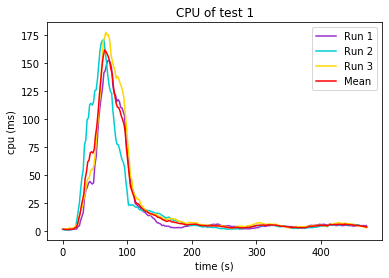

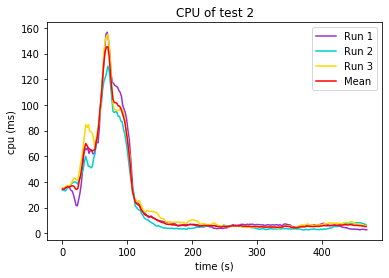

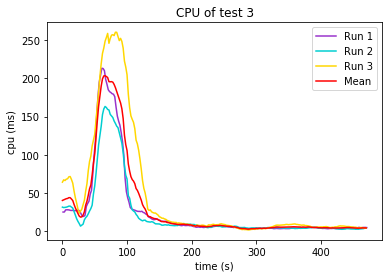

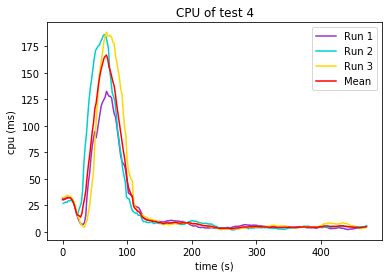

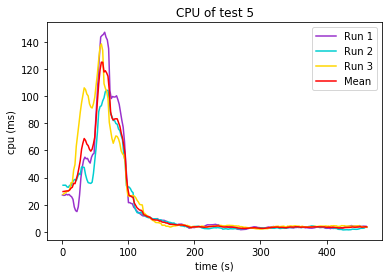

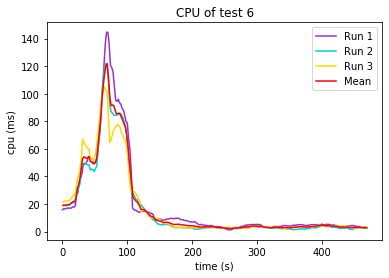

In [28]:
import matplotlib.pyplot as plt

for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = dict_test_values["Test_" + str(index_test + 1) + "_time"][index]
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = dict_test_values["Test_" + str(index_test + 1) + "_time"][index]
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    ax.set_title('CPU of test ' + str(index_test + 1))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('cpu (ms)')
    leg = ax.legend();
    plt.show()

# CPU of all tests

In [29]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"][0])

dict_test["times"], dict_test["values"] = fix_duration(dict_test["values"], dict_test["times"])

ValueError: `bins` must increase monotonically, when an array

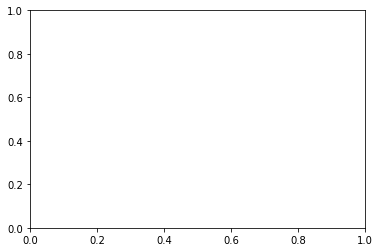

In [106]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)

fig, ax = plt.subplots()
    
for index in range(1):
    x = dict_test["times"][index]
    y = dict_test["values"][index]
    
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    entries, bin_edges, patches = plt.hist(, bins=y, density=False, label='Data')

    # calculate bin centres
    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries)
   
    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    x_plot = np.arange(0, 250)

    plt.plot(
        x_plot,
        fit_function(x_plot, *parameters),
        marker='o', linestyle='',
        label='Fit result',
    )
    leg = ax.legend();
ax.set_title('CPU of ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('cpu (ms)')
plt.show()

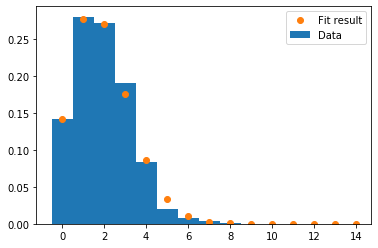

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson

# get poisson deviated random numbers
data = np.random.poisson(2, 1000)

# the bins should be of integer width, because poisson is an integer distribution
bins = np.arange(11) - 0.5
entries, bin_edges, patches = plt.hist(data, bins=bins, density=True, label='Data')

# calculate bin centres
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])


def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)


# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries)

# plot poisson-deviation with fitted parameter
x_plot = np.arange(0, 15)

plt.plot(
    x_plot,
    fit_function(x_plot, *parameters),
    marker='o', linestyle='',
    label='Fit result',
)
plt.legend()
plt.show()


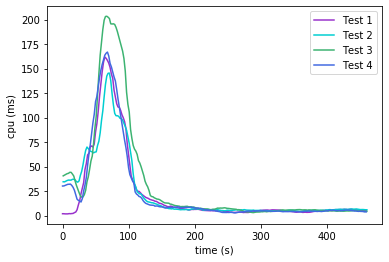

In [30]:
fig, ax = plt.subplots()
        
for index in range(TEST_NUMBER - 2):
    x = dict_test["times"][index]
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('CPU of ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('cpu (ms)')
plt.savefig("CPU_ELIoT_tests.png")

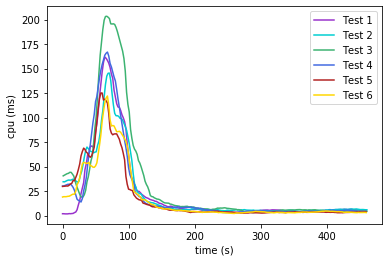

In [32]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = dict_test["times"][index]
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('CPU of all tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('cpu (ms)')
plt.savefig("cpu_all_tests.png")